# Artificial Intelligence UE
## Exercises 3 - Game Playing

In this series of exercises you are looking at game playing - more precisely, at the Minimax algorithm, Alpha-Beta pruning and Q-Learning. 

The algorithms have been explained in the lecture (VO) and we gave you some additional information in the exercise (UE). Please refer to the lecture slides (VO) for the pseudo algorithms and the exercise slides (UE) for additional hints.

<div class="alert alert-warning">

<p><strong>Practical hints:</strong></p>
<ul>
<li>Replace the placeholders <code># YOUR CODE HERE</code>, <code>raise NotImplementedError()</code> with your code.</li>
<li>Do not rename any of the already existing variables (this might lead to tests failing / not working).</li>
<li>if you want a number smaller than all others, you may use <code>float('-Inf')</code></li>
<li>if you want a number larger than all others, you may use <code>float('Inf')</code></li>
</ul>
</div>


In [5]:
# import stuff
from pig_lite.game.base import Game, Node
from pig_lite.environment.base import Environment, Outcome
from pig_lite.instance_generation.problem_factory import ProblemFactory

import math
import random
import numpy as np

## Small Intro into the World of TicTacToe

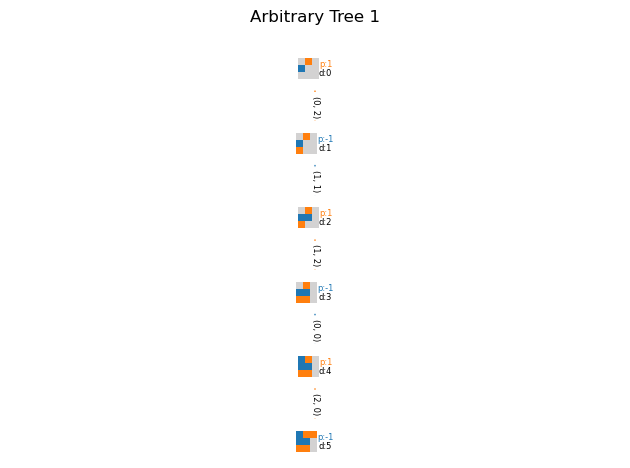

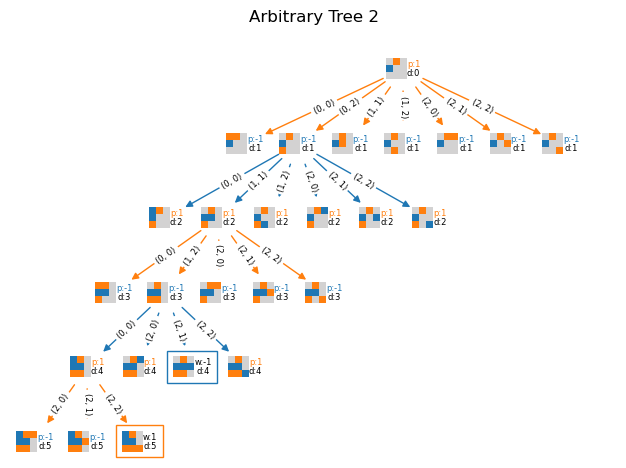

In [6]:
# you can generate a new game board of TicTacToe as follows; note that the problem_size here describes the depth of the board in a game tree
rng = np.random.RandomState(seed=123)
game = ProblemFactory().generate_problem('tictactoe', problem_size=3, rng=rng)

# or, you can load an existing one from a .json file like so:
game = ProblemFactory().create_problem_from_json(json_path='boards/game.json')

# if we use Minimax / Alphabeta pruning to derive a move sequence, we can visualise it as follows:
move_sequence = [(-1, (0, 2)), (1, (1, 1)), (-1, (1, 2)), (1, (0, 0)), (-1, (2, 0))] # arbitrary move sequence for demonstration purposes
game.visualize(move_sequence, show_possible=False, tree_name='Arbitrary Tree 1')
# if we set show_possible to True, the function shows all possible moves from a state in the path
game.visualize(move_sequence, show_possible=True, tree_name='Arbitrary Tree 2')

## Minimax

Now, let us implement the Minimax algorithm!

**NOTE**: If multiple paths lead to the same outcome for these algorithms, choose the first expanded / leftmost path.

Game terminated: True, winner is: 1 (1: Max, -1: Min); nr of expanded nodes: 4024
State of the board:


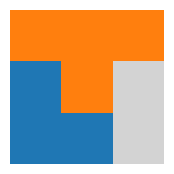

Performed moves: 5


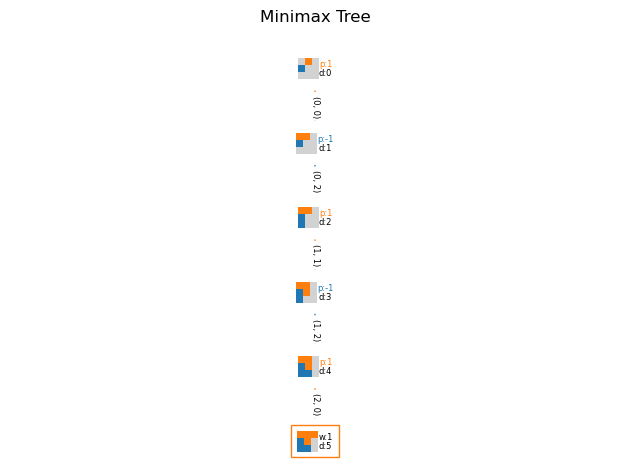

In [7]:
class Minimax():
    def play(self, game: Game):
        """ Starts game playing, and returns found terminal node according to minimax. """
        start = game.get_start_node()
        # 'game.get_max_player()' asks the game how it identifies the MAX player internally
        value, terminal_node = self.minimax(game, start, game.get_max_player())
        return terminal_node

    def minimax(self, game, node, max_player):
        """ Performs minimax algorithm (recursively). """
        # here we check if the current node 'node' is a terminal node
        terminal, winner = game.outcome(node)

        # if it is a terminal node, determine who won, and return
        # a) the utility value (-1, 0, 1)
        # and b) the terminal node itself, to be able to determine the path of moves/plies that led to this terminal node
        if terminal:
            if winner is None:
                return 0, node
            elif winner == max_player:
                return 1, node
            else:
                return -1, node

        if node.player == max_player:
            # you have to remember the best value *and* the best node for the MAX player (TODO: initialise appropriately)
            best_value, best_node = float('-inf'), None

            for child in game.successors(node):
                value, terminal_node = self.minimax(game, child, max_player)

                if value > best_value:
                    best_value = value
                    best_node = terminal_node

            return best_value, best_node
        else:
            # you have to remember the best value *and* the best node for the MIN player (TODO: initialise appropriately)
            best_value, best_node = float('inf'), None

            for child in game.successors(node):
                value, terminal_node = self.minimax(game, child, max_player)

                if value < best_value:
                    best_value = value
                    best_node = terminal_node
                    
            return best_value, best_node

game = ProblemFactory().create_problem_from_json(json_path='boards/game.json')
outcome = Minimax().play(game)
minimax_nodes = game.get_number_of_expanded_nodes()

if outcome is not None:
    terminated, winner = game.outcome(outcome)
    print('Game terminated: {}, winner is: {} (1: Max, -1: Min); nr of expanded nodes: {}'.format(terminated, winner, minimax_nodes))
    outcome.pretty_print()
    game.visualize(game.get_move_sequence(outcome), False, 'Minimax Tree')   

### Minimax Checks

In [8]:
# check found path here 
assert(outcome is not None), 'Minimax returned None, something is wrong with the implementation'
# this check tests whether you really chose the left-most path
game = ProblemFactory().create_problem_from_json(json_path='boards/game.json')
outcome = Minimax().play(game)
terminated, winner = game.outcome(outcome)
assert(terminated == True), 'Minimax did not return a terminal node, so likely wrong node was returned'
assert(game.get_move_sequence_hash(outcome) != 'b68a7dd18dfc7694da1b25e0290903b4d2fedba66c8d090c0d11923f5e2c8d22'), 'Minimax did not find correct move sequence, likely due to not taking the first expanded optimal path for MAX player'
assert(game.get_move_sequence_hash(outcome) != 'fc8ecbd22f45983e14e43ef4cdd120252913898e521f2712cd9d07b8913cade0'), 'Minimax did not find correct move sequence, likely due to not taking the first expanded optimal path for MIN player'
assert(game.get_move_sequence_hash(outcome) != 'c263685af9af51da439db5aa6714bb39845ad19f2d9f7c4279e9b9c086559e46'), 'Minimax did not find correct move sequence, likely due to not taking the first expanded optimal path for MAX+MIN player'
assert(game.get_move_sequence_hash(outcome) == 'bfb38fb43f84847e4b001d09dcb22cfe573f41efac370e118f3b6630fd0f259a'), 'Minimax did not find correct move sequence to terminal state for the provided problem instance'
print('Minimax found correct terminal node and move sequence leading to it for provided problem instance')

Minimax found correct terminal node and move sequence leading to it for provided problem instance


In [9]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe1.json')
outcome = Minimax().play(game)
assert(outcome is not None), 'Minimax returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert(np.all(outcome.state.T == np.array([[1, -1, -1], [-1, 1, 1], [1, -1, -1]]))), 'Minimax did not find correct terminal node for private instance 1, maybe wrong node was returned or minimax has an error'
assert(game.get_move_sequence_hash(outcome) == '4e49e7612322365aceaccd3a80dca6c4836c0d7196593c785d9e3da7960fe2ea'), 'Minimax did not find correct move sequence to terminal state of private problem instance 1'
print('Minimax found correct terminal node and move sequence leading to it for private problem instance 1')

Minimax found correct terminal node and move sequence leading to it for private problem instance 1


In [10]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe2.json')
outcome = Minimax().play(game)
assert(outcome is not None), 'Minimax returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert not (game.get_move_sequence_hash(outcome) == 'bba1199f0c4f21f58aac340189660bc99a8b50ded6a227f7f0b2039572b627c4' or
      np.all(outcome.state.T == np.array([[-1, 0, 1], [0, 0, 1], [0, -1, 1]]))), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MAX player'
assert not (game.get_move_sequence_hash(outcome) == '45940174f9875ce563c45439c8d86b4d1eed0ebaa6947a4587f93bb28bf44476' or
       np.all(outcome.state.T == np.array([[1, 0, 1], [1, 0, -1], [1, -1, -1]]))), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MIN player'
assert not (game.get_move_sequence_hash(outcome) == '1961082c8650fc498c973b099e4b0c12edba87a04eaf278d5a4e6389364c694e' or
       np.all(outcome.state.T == np.array([[0, -1, 1], [0, 1, -1], [1, -1, 1]]))), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MAX+MIN player'
assert(game.get_move_sequence_hash(outcome) == '79e76d8da84c876fcd145e25d88601e2997d9557004c0b969b4402ddb9185f78' and
       np.all(outcome.state.T == np.array([[1, -1, 1], [-1, 1, 0], [1, -1, 0]]))), 'Minimax did not find correct move sequence to terminal state or terminal node for the provided problem instance'
print('Minimax found correct terminal node and move sequence leading to it for private problem instance 2')

Minimax found correct terminal node and move sequence leading to it for private problem instance 2


In [11]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe3.json')
outcome = Minimax().play(game)
assert(outcome is not None), 'Minimax returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert not (game.get_move_sequence_hash(outcome) == '1b585860ffb92cd318887950c257f7f12d9e0555ae849ffd2b2fad8caf66e8e6' or
      np.all(outcome.state.T == np.array([[-1, 0, 1],[-1, 1, 1],[1, -1, 0]]))), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MAX player'
assert not (game.get_move_sequence_hash(outcome) == 'b4b1d966698346de24c319905e52877e0afefe1a2b9e60f9b4f314fbdc25d9d5' or
       np.all(outcome.state.T == np.array([[1, 0, 0], [1, 1, -1], [1, -1, -1]]))), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MIN player'
assert not (game.get_move_sequence_hash(outcome) == 'fdb559d7f1b35a9f0a01e2b857c2c592cba1c691292aef491db2a1b89164ed1b' or
       np.all(outcome.state.T == np.array([[0, 0, -1], [1, 1, 1], [1, -1, -1]]))), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MAX+MIN player'
assert(game.get_move_sequence_hash(outcome) == '20576ffcccc1fa1d6081497f283229761012385ffd5c34f86547801cba3ffead' and
       np.all(outcome.state.T == np.array([[-1, -1, 1], [1, 1, 0], [1, -1, 0]]))), 'Minimax did not find correct move sequence to terminal state or terminal node for the provided problem instance'
print('Minimax found correct terminal node and move sequence leading to it for private problem instance 3')

Minimax found correct terminal node and move sequence leading to it for private problem instance 3


In [12]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe4.json')
outcome = Minimax().play(game)
assert(outcome is not None), 'Minimax returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert(np.all(outcome.state.T == np.array([[1, -1, 1], [1, -1, 1], [-1, 1, -1]]))), 'Minimax did not find correct terminal node for private instance 4, maybe wrong node was returned or minimax has an error'
assert (game.get_move_sequence_hash(outcome) != '1dfb09398dc0726119c331fe7134cf22085cb8b7e9fb32ff8358a5675c2e40a0'), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MAX player'
assert (game.get_move_sequence_hash(outcome) != '26c69f8c65d0f1cdac09aafcc00d4ba0ce03fd9336d1977928100481f7570ee7'), 'Minimax did not find correct move sequence or terminal node, likely due to not taking the first expanded optimal path for MIN or MAX+MIN player'
assert(game.get_move_sequence_hash(outcome) == '49e861565ea87b3b2e555c75dc1835b8c030ac0bf55da27c3f4efd2f3585e6ca'), 'Minimax did not find correct move sequence to terminal state or terminal node for the provided problem instance'
print('Minimax found correct terminal node and move sequence leading to it for private problem instance 4')

Minimax found correct terminal node and move sequence leading to it for private problem instance 4


## Alpha-Beta Pruning

Here, let us implement Alpha-Beta pruning. 

**NOTE**: If multiple paths lead to the same outcome for these algorithms, choose the first expanded / leftmost path.

Game terminated: True, winner is: 1 (1: Max, -1: Min); nr of expanded nodes: 266
State of the board:


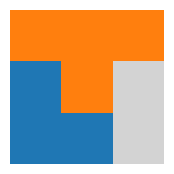

Performed moves: 5


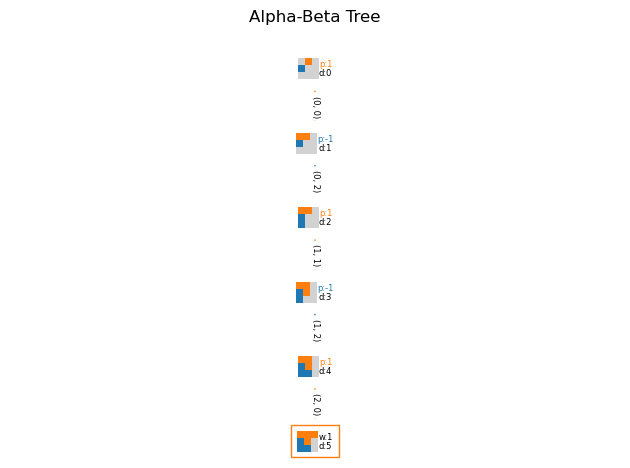

In [13]:
class AlphaBeta(object):
    def play(self, game: Game):
        """ Starts game playing, and returns found terminal node according to alpha-beta pruning. """
        start = game.get_start_node()
        alpha = float('-Inf')
        beta = float('Inf')
        value, terminal_node = self.alphabeta(game, start, alpha, beta, game.get_max_player())
        return terminal_node

    def alphabeta(self, game, node, alpha, beta, max_player):
        """ Performs alpha-beta pruning algorithm (recursively). """
        # here we check if the current node 'node' is a terminal node
        terminal, winner = game.outcome(node)
        # if it is a terminal node, determine who won, and return
        if terminal:
            if winner is None:
                return 0, node
            elif winner == max_player:
                return 1, node
            else:
                return -1, node

        if node.player == max_player:
            # you have to remember the best value *and* the best node for the MAX player (TODO: initialise appropriately)
            best_value, best_node = float('-inf'), None

            for child in game.successors(node):
                value, terminal_node = self.alphabeta(game, child, alpha, beta, max_player)
                alpha = max(alpha, value)

                if value > best_value:
                    best_value = value
                    best_node = terminal_node

                if alpha >= beta:
                    break;

            return best_value, best_node
        else:
            # you have to remember the best value *and* the best node for the MIN player (TODO: initialise appropriately)
            best_value, best_node = float('inf'), None

            for child in game.successors(node):
                value, terminal_node = self.alphabeta(game, child, alpha, beta, max_player)
                beta = min(beta, value)

                if value < best_value:
                    best_value = value
                    best_node = terminal_node

                if beta <= alpha:
                    break;
                    
            return best_value, best_node

game = ProblemFactory().create_problem_from_json(json_path='boards/game.json')
outcome = AlphaBeta().play(game)
alphabeta_nodes = game.get_number_of_expanded_nodes()

if outcome is not None:
    terminated, winner = game.outcome(outcome)
    print('Game terminated: {}, winner is: {} (1: Max, -1: Min); nr of expanded nodes: {}'.format(terminated, winner, alphabeta_nodes))
    outcome.pretty_print()
    game.visualize(game.get_move_sequence(outcome), False, 'Alpha-Beta Tree')   

### Alpha-Beta Pruning Checks

In [14]:
# check found path here 
assert(outcome is not None), 'Alpha-beta pruning returned None, something is wrong with the implementation'

game = ProblemFactory().create_problem_from_json(json_path='boards/game.json')
outcome = AlphaBeta().play(game)
terminated, winner = game.outcome(outcome)
assert(terminated == True), 'Alpha-beta pruning did not return a terminal node, so likely wrong node was returned'
assert(game.get_move_sequence_hash(outcome) != 'f224894cb163f1fd5530927610c3c2667f6c5141c2c026f6fd9e7f6ace1e4bb8'), 'Alpha-beta pruning did not find correct move sequence, likely due to not taking the first expanded optimal path for MAX(+MIN) player'
assert(game.get_move_sequence_hash(outcome) != 'fc8ecbd22f45983e14e43ef4cdd120252913898e521f2712cd9d07b8913cade0'), 'Alpha-beta pruning did not find correct move sequence, likely due to not taking the first expanded optimal path for MIN player'
assert(np.all(outcome.state.T == np.array([[1, 1, 1], [-1, 1, 0], [-1, -1, 0]]))), 'Alpha-beta did not find correct terminal node, maybe wrong best node was stored'
assert(game.get_move_sequence_hash(outcome) == 'bfb38fb43f84847e4b001d09dcb22cfe573f41efac370e118f3b6630fd0f259a'), 'Alpha-beta did not find correct move sequence to terminal state'
print('Alpha-beta pruning found correct terminal node and move sequence leading to it for provided problem instance')

Alpha-beta pruning found correct terminal node and move sequence leading to it for provided problem instance


In [15]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe1.json')
outcome = AlphaBeta().play(game)
assert(outcome is not None), 'Alpha-beta pruning returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert(np.all(outcome.state.T == np.array([[1, -1, -1], [-1, 1, 1], [1, -1, -1]]))), 'Alpha-beta did not find correct terminal node for private instance 1, maybe wrong node was returned or minimax has an error'
assert(game.get_move_sequence_hash(outcome) == '4e49e7612322365aceaccd3a80dca6c4836c0d7196593c785d9e3da7960fe2ea'), 'Alpha-beta did not find correct move sequence to terminal state for private problem instance 1'
print('Alpha-beta pruning found correct terminal node and move sequence leading to it for private problem instance 1')

Alpha-beta pruning found correct terminal node and move sequence leading to it for private problem instance 1


In [16]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe_draw_5x5.json')
outcome = AlphaBeta().play(game)
assert(outcome is not None), 'Alpha-beta pruning returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert(game.get_move_sequence_hash(outcome) != '7b8a98f36acbd985721d447bd59a9dacc987e31d5d8d2ccafaabe6891cc3de39'), 'Alpha-beta pruning did not find correct move sequence, likely due to not taking the first expanded optimal path for MAX(+MIN) player' 
assert(game.get_move_sequence_hash(outcome) != 'f728a654955355bc35f3f4ca86a0b409a0febf600899828db999bbe4118a2f65'), 'Alpha-beta pruning did not find correct move sequence, likely due to not taking the first expanded optimal path for MIN player' 
assert(game.get_move_sequence_hash(outcome) == 'f472a4657161dd8c11256060a52fca0cd9ef075cb0bdd6f809319162cd26bba2'), 'Alpha-beta did not find correct move sequence to terminal state for private problem instance 2'
print('Alpha-beta pruning found correct terminal node and move sequence leading to it for private problem instance 2')

Alpha-beta pruning found correct terminal node and move sequence leading to it for private problem instance 2


In [17]:
game = ProblemFactory().create_problem_from_json(json_path='boards/tictactoe_win_5x5.json')
outcome = AlphaBeta().play(game)
assert(outcome is not None), 'Alpha-beta pruning returned None, this can have various reasons; e.g., you might have not or incorrectly updated the best value / node, or the update check was wrong (val > best_value for MAX, val < best_value for MIN)'
assert(game.get_move_sequence_hash(outcome) == 'da4f6dd7b0fa7fbd53f6191111e7fdbf1082d6c8a41704b981d36bbb016f039d' or
       game.get_move_sequence_hash(outcome) == '491ace3d81d89d79836ef6919b3d77c9c9a081cdf51de6941403a2ae07ca0dd3'), 'Alpha-beta did not find correct move sequence to terminal state for private problem instance 3'
print('Alpha-beta pruning found correct terminal node and move sequence leading to it for private problem instance 3')

Alpha-beta pruning found correct terminal node and move sequence leading to it for private problem instance 3


In [18]:
# check expanded nodes here (whether we actually save something compared to minimax)
assert(alphabeta_nodes <= minimax_nodes), 'Alpha-beta pruning took more node expansions than minimax - something must be off here...'
game_ab = ProblemFactory().create_problem_from_json(json_path='boards/game.json')
game_mm = ProblemFactory().create_problem_from_json(json_path='boards/game.json')
out_ab = AlphaBeta().play(game_ab)
out_mm = Minimax().play(game_mm)
assert(not(game_ab.get_number_of_expanded_nodes() == game_mm.get_number_of_expanded_nodes() and game_ab.get_move_sequence_hash(out_ab) == game_mm.get_move_sequence_hash(out_mm))), 'Seems like alpha-beta pruning behaves as minimax, nothing was pruned for the provided test instance'
assert(not(game_ab.get_number_of_expanded_nodes() == 354 or game_ab.get_number_of_expanded_nodes() == 360 or game_ab.get_number_of_expanded_nodes() == 640 or
       game_ab.get_number_of_expanded_nodes() == 839 or game_ab.get_number_of_expanded_nodes() == 3079)), 'Did not expand correct number of nodes for alpha-beta pruning, likely either used pruning for MIN/MAX only, or used </> instead of <=/=>'
assert(game_ab.get_number_of_expanded_nodes() == 266), 'Did not expand correct number of nodes for alpha-beta pruning, likely due to wrong pruning condition (should be alpha >= beta for MAX, beta <= alpha for MIN)'
print('Pruning seems okay')

Pruning seems okay


## Small Intro into the Gridworld

<div class="alert alert-info">
For Q-Learing, we require another new problem type - we here look at a stochastic gridworld.
</div>

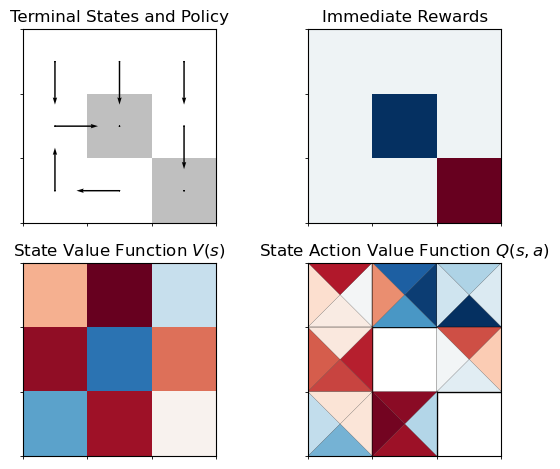

In [19]:
# you can generate a new gridworld as follows
rng = np.random.RandomState(seed=123)
env = ProblemFactory().generate_problem('gridworld', problem_size=3, rng=rng)

# or, you can load an existing one from a .json file like so:
env_json = ProblemFactory().create_problem_from_json(json_path='boards/environment.json')

# if we use Q-Learning to learn the Q-function, we can visualise its results as follows:
rand_policy = np.array([[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0]])
outcome = Outcome(n_episodes=1, policy=rand_policy, V=np.random.randn(env.get_n_states()),       # arbitrary outcome for demonstration purposes
                  Q=np.random.randn(env.get_n_states(), env.get_n_actions())) 
env.visualize(outcome)

## Q-Learning
   
<strong>Remember: To interact with the (Q-Learning) enviroment, you need</strong>
<ul>
<li><code>state = env.reset()</code> to reset the environment at the start of an episode</li>
<li><code>state, reward, done = env.step(action)</code> to tell the environment that your agent decided to take `action`. The environment then tells you in which state you actually ended up in (<code>state</code>), what the immediate reward was (<code>reward</code>), and whether or not the episode ended (<code>done</code>).</li>
<li>If the test takes significantly longer than ~20 seconds you probably have an error in your update step of the state-action function</li>
  
</ul>

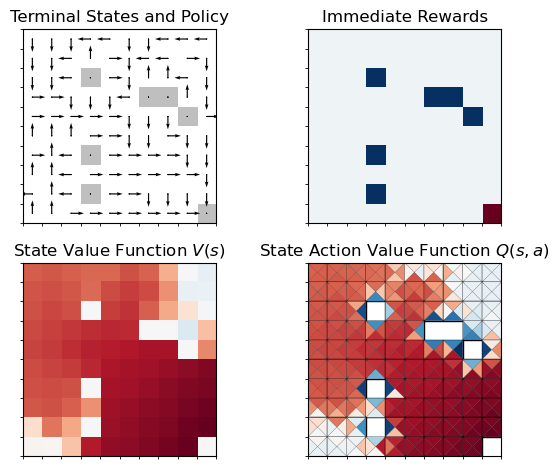

In [20]:
def eps_greedy(rng, qs, epsilon):
    """ Makes an epsilon greedy decision between exploration (trying out a new option)
        and exploitation (choosing best option so far). """
    if rng.uniform(0, 1) < epsilon:
        # with probability p == epsilon, an action is chosen uniformly at random
        # YOUR CODE HERE
        return rng.randint(len(qs))
    else:
        # with probability p == 1 - epsilon, the action having the currently largest q-value estimate is chosen
        # YOUR CODE HERE
        return np.argmax(qs)

class QLearning():
    def train(self, env: Environment, n_episodes=10000, alpha=0.2):
        """ Performs Q-Learning for given environment. """
        # leave untouched for the sake of reproducibility (tests below rely on these fixed values)
        self.rng = np.random.RandomState(1234)
        self.epsilon = 0.3
        self.gamma = env.get_gamma()

        # initialize the Q-'table'
        Q = np.zeros((env.get_n_states(), env.get_n_actions()))

        for episode in range(1, n_episodes + 1):
            # implement q-learning update here: generate an episode, interact with environment with env.reset() and env.step(action)
            # YOUR CODE HERE
            done = False
            state = env.reset()

            while not done:
                action = eps_greedy(self.rng, Q[state], self.epsilon)
                next_state, reward, done = env.step(action)

                best_next_q = np.max(Q[next_state])
                td_target = reward + self.gamma * best_next_q

                Q[state, action] += alpha * (td_target - Q[state, action])
                state = next_state

        # compute a deterministic policy from the Q value function
        policy = np.zeros((env.get_n_states(), env.get_n_actions()), dtype=np.int64)
        policy[np.arange(len(policy)), np.argmax(Q, axis=1)] = 1
        # finally, compute the state value function V here
        # it can be computed easily from Q by taking the action that leads to the max future reward
        V = np.max(Q, axis=1)
        
        return Outcome(n_episodes, policy, V=V, Q=Q)

environment = ProblemFactory().create_problem_from_json(json_path='boards/environment.json')
qlearn = QLearning()
outcome = qlearn.train(environment)

if outcome is not None:
    environment.visualize(outcome)

### Q-Learning Checks

In [21]:
# here we check whether default variables were modified
assert(qlearn.epsilon == 0.3), 'Epsilon was changed for Q-Learning'
assert(qlearn.gamma == environment.get_gamma()), 'Gamma was changed for Q-Learning'

In [22]:
# here we check a few test instances for their resulting policy (encoded in a hash-value)
# first two hashes are obtained by using q-learning update with alpha, second two hashed w/o alpha
assert(environment.get_policy_hash(outcome) != 'f35de3a82ae52dc2c67cacc7942b85785a35ba188a20454ccbdf77627b6695c8'), 'Make sure to use both the current and the next state in your Q function update'
assert(environment.get_policy_hash(outcome) == 'a138e26bebdd61e38fc045f03a37ee77bc3343dc36cb3f1cf415707a9b5e08ad' or
       environment.get_policy_hash(outcome) == '6c8ec07e309222af5c0839f8a6fb58597135356f451dc61c624a1ebea86735fe' or
       environment.get_policy_hash(outcome) == '7e730a7445950f7a9c8125c96d0d45066f995833f08e4ea585b38ce93a6313e0' or
       environment.get_policy_hash(outcome) == 'af0dc1e412f6985a939691b3f589f89a3fb5d696a3cde67d33438024d14223e9'), 'algorithm did not find the same optimal policy as ours, so there is probably something off'

env = ProblemFactory().create_problem_from_json(json_path='boards/gridworld1.json')
out = QLearning().train(env)
assert(env.get_policy_hash(out) == 'ca2e78d44dacc2645876957f1e10393b77c933a94c562f845025d31b3dc062c4' or
       env.get_policy_hash(out) == 'c14762db6d5f332ae89cb4209cf460fa9eecffdee197383fa043b2c6ef00b76c' or
       env.get_policy_hash(out) == '0ceffffae674a851c603e971597718b70d2dce2ed6e38ffc925fbc5a81d8aebf'), 'Q-Learning did not find the same policy as ours; this could be due to incorrect update function (or other aspects, see remaining comments regarding tests)'
print('The Q-learning implementation found the same policy as ours for a new test instance!')

The Q-learning implementation found the same policy as ours for a new test instance!


In [23]:
# here we check whether eps_greedy was implemented (correctly)
assert(eps_greedy(qlearn.rng, outcome.Q[environment.reset()], qlearn.epsilon) != -1), 'eps_greedy does not appear to be implemented (correctly) yet'


rng = np.random.RandomState(12)
print('Test of eps_greedy sampling, random sampling with epsilon = 0.5 and random state = 12:')
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 2), 'first step should be random action, eps_greedy does not work as expected, make sure to use the passed rng to select randomly'
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 3), 'second step should be argmax of Q, eps_greedy does not work as expected'
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 3), 'third step should be random action, eps_greedy does not work as expected, make sure to use the passed rng to select randomly'
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 2), 'fourth step should be random action, eps_greedy does not work as expected, make sure to use the passed rng to select randomly'
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 1), 'fifth step should be random action, eps_greedy does not work as expected, make sure to use the passed rng to select randomly'
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 2), 'sixth step should be random action, eps_greedy does not work as expected, make sure to use the passed rng to select randomly'
assert(eps_greedy(rng, [59.23768459, 59.86590956, 59.15508216, 60.56009166], 0.5) == 3), 'seventh step should be argmax of Q, eps_greedy does not work as expected'
print('Seems to work fine!')

Test of eps_greedy sampling, random sampling with epsilon = 0.5 and random state = 12:
Seems to work fine!


In [24]:
# here we check whether eps_greedy was called in your QLearning implementation
import ast
import inspect
call_names = [c.func.id for c in ast.walk(ast.parse(inspect.getsource(QLearning.train).lstrip()))
              if isinstance(c, ast.Call) and not isinstance(c.func, ast.Attribute)] 
assert('eps_greedy' in call_names), 'eps_greedy function was not used during training to sample next action'

In [25]:
# here we check whether V was computed (correctly)
assert(outcome.V is not None), 'V was not computed (correctly)'
assert(np.allclose(outcome.V, [60.56009166229519, 62.0862976417879, 59.69673685231367, 57.2998914308495, 57.16247167797613, 63.72475795338036, 58.681549989922765, 36.160081000906104, -0.7346191191046638, -7.957286438234731, 
                               62.429613717496785, 64.27021333475943, 61.8489623068024, 56.68931070289786, 64.7086260941021, 68.96740198280624, 64.72192080370876, 45.42333812841379, -7.70660099982711, -6.3540660505033255, 
                               63.78874659772162, 66.28022856039745, 64.26691771606903, 0.0, 69.00293688866753, 72.11660041265043, 59.602399420640545, 38.030496836206275, 14.299440372492398, -1.636243819995724, 
                               65.60578892848311, 68.06355849549294, 70.76043474466302, 73.52559642373782, 74.829413699787, 74.7244884571062, 0.0, 0.0, -14.372316463840185, 30.32359198821047, 
                               67.45442443720407, 69.98858830119075, 73.64652924428802, 76.45223284842137, 78.6024777398158, 80.19432277767568, 81.97087573052612, 81.87190792575387, 0.0, 47.6790177531604, 
                               65.25444937464933, 67.06361233729368, 70.09899795480531, 74.8512985464834, 80.99319093176972, 82.70891686090964, 84.1063933238421, 87.10476457339571, 89.55648769695577, 92.02018276648413, 
                               63.98216126752015, 64.78481366263227, 63.37994143735609, 0.0, 83.06026652598523, 84.14552727908097, 86.80838516636535, 89.91640697830174, 92.07232887476961, 94.00906431697199, 
                               61.66891093157388, 63.80128024721642, 59.39816181823294, 45.550034604437634, 84.31066865743784, 86.72480155341584, 89.00776722138832, 91.72422981845112, 94.69912447457426, 97.00665363583768, 
                               17.818059604934152, 53.73008677587408, 38.607997303469254, 0.0, 86.4088656035926, 88.63000118406423, 90.8302457235381, 93.48189534830975, 96.7290118179945, 99.76915525815585, 
                               2.7869296811856383, 1.9107575717432566, 28.481804693589865, 79.17530638335536, 88.17997020406862, 89.31582272957053, 92.06318449933205, 95.62679684531966, 98.34285013960046, 0.0]) or 
       np.allclose(outcome.V, [65.23372476711732, 54.00862916103103, 55.56427187982933, 57.13562816144377, 57.13562816144377, 60.32611790780917, 58.72285672873108, 60.32611790780917, 60.32611790780917, 73.74916255379564, 
                               66.9027522900175, 68.58863867678535, 54.00862916103103, 58.72285672873108, 63.58138751944615, 58.72285672873108, 70.29155421897511, 65.23372476711732, 63.58138751944615, 86.41306958139799, 
                               66.9027522900175, 70.29155421897511, 54.00862916103103, 0.0, 65.23372476711732, 77.27697434322585, 72.01167092825769, 66.9027522900175, 63.58138751944615, 84.54893888558401, 
                               70.29155421897511, 68.58863867678535, 77.27697434322585, 75.50420459979358, 80.87641500176089, 79.06765085174328, 0.0, 0.0, -100.0, 86.41306958139799, 
                               72.01167092825769, 73.74916255379564, 75.50420459979358, 77.27697434322585, 82.70344949672817, 80.87641500176089, 82.70344949672817, 84.54893888558401, 0.0, 86.41306958139799, 
                               73.74916255379564, 73.74916255379564, 73.74916255379564, 75.50420459979358, 84.54893888558401, 86.41306958139799, 80.87641500176089, 90.19800998, 92.119202, 94.0598, 
                               68.58863867678535, 70.29155421897511, 75.50420459979358, 0.0, 80.87641500176089, 86.41306958139799, 82.70344949672817, 88.2960298802, 94.0598, 96.02, 
                               66.9027522900175, 58.72285672873108, 60.32611790780917, 61.94557364425169, 84.54893888558401, 86.41306958139799, 92.119202, 90.19800998, 94.0598, 98.0, 
                               60.32611790780917, 58.72285672873108, 60.32611790780917, 0.0, 82.70344949672817, 88.2960298802, 92.119202, 96.02, 94.0598, 100.0, 
                               57.13562816144377, 58.72285672873108, 58.72285672873108, 58.72285672873108, 92.119202, 82.70344949672817, 96.02, 98.0, 100.0, 0.0])), 'Your computed V does not match our solution'
print('V seems to be computed correctly!')

V seems to be computed correctly!


In [26]:
# here we check whether the update function is correctly implemented
rng = np.random.RandomState(12)
env = ProblemFactory().generate_problem('gridworld', problem_size=3, rng=rng)
q_approx = QLearning().train(env, 1).Q
assert(np.allclose(q_approx, np.array([[-0.36, -0.2, -0.3996, -0.2], [-0.2, 0., 0., 0.], [0., 0., 0., 0.,], [-0.2, -20., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.,], [0., 0., 0., 0.], [0., 0., 0., 0.]])) or
       np.allclose(q_approx, np.array([[-1., -1., -1.99, -1.], [-1., 0., 0., 0.], [0., 0., 0., 0.,], [-1., -100., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.,], [0., 0., 0., 0.], [0., 0., 0., 0.]]))), 'Q-values are wrong for this instance, probably the update function is wrongly implemented'
env = ProblemFactory().generate_problem('gridworld', problem_size=3, rng=rng)
q_approx = QLearning().train(env, 2).Q
assert(np.allclose(q_approx, np.array([[-0.3996, -0.488, -0.3996, -0.488], [-0.2, -0.2, -0.39168, -0.27128], [-0.2, 0., 0., 0.], [-0.3996, -20., -0.2396, -0.3996], [0., 0., 0., 0.], [0., 0., 0., 0.], [-0.3996, -0.36, -0.2396, -0.2], [-0.2, 20., 0., 0.], [0., 0., 0., 0.]])) or
       np.allclose(q_approx, np.array([[-1.99, -1.99, -1., -1.], [-1.99, -1., -1.99, -100.], [-1., -1., -1., -1.], [0., 0., -1.99, 0.], [0., 0., 0., 0.], [-100., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]]))), 'Q-values are wrong for this instance, probably the update function is wrongly implemented'
print('Q-update looks correct as well')

Q-update looks correct as well
